# Image Classification with CNN

In [5]:
! pip install datasets opencv-python-headless opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


## 1. Import Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter
from typing import List, Tuple
from copy import deepcopy
import itertools

import cv2
from PIL import Image
from skimage.transform import resize

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from datasets import load_dataset, Dataset

Seed for reproducibility:

In [7]:
random.seed(1)

## 2. Load Data

In [8]:
# 1. Load the caltech-256 dataset
caltech256 = load_dataset("bitmind/caltech-256")

# 2. Explore the dataset structure
print("\nDataset structure:")
print(caltech256)
print(f"\nNumber of training examples: {len(caltech256)}")


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'filename'],
        num_rows: 30607
    })
})

Number of training examples: 1


## 3. Data Exploration and Subsetting

First the `extract_label` function is defined to parse class names from image filenames. This function is then applied to the entire `caltech256` dataset.

After, the 'train' split of the processed dataset is assigned to `train_dataset`.

In [9]:
# Extract labels from the 'filename' feature in the training dataset
def extract_label(example):
    example['class'] = example['filename'].split('.')[1].split('/')[0]
    return example

# Apply the function to the training, validation, and test datasets
caltech256 = caltech256.map(extract_label)

train_dataset = caltech256['train']

Map:   0%|          | 0/30607 [00:00<?, ? examples/s]

Labels extracted successfully!


Examine Data Structure

In [10]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=230x230>,
 'filename': '138.mattress/138_0117.jpg',
 'class': 'mattress'}

Examine and Filter classes

In [11]:
# Extract unique class names from the training dataset
uniqtrain_dataset = train_dataset.unique('class')
# Print the unique class names
class_names = list(uniqtrain_dataset)
print(f"\nUnique class names: {class_names[:20]}, (...)]")

# Print the number of unique classes
print(f"Number of unique classes: {len(class_names)}")



Unique class names: ['mattress', 'hot-air-balloon', 'chess-board', 'buddha-101', 'butterfly', 'mailbox', 'gas-pump', 'ostrich', 'stained-glass', 'skateboard', 'homer-simpson', 'yo-yo', 'fireworks', 'snake', 'tombstone', 'baseball-glove', 'spider', 'chopsticks', 'bear', 'socks'], (...)]
Number of unique classes: 257


In [12]:
selected_classes = ['airplanes-101','motorbikes-101','faces-easy-101','t-shirt','billiards','horse']
# Filter the training dataset to include only the selected classes
filtered_dataset = train_dataset.filter(lambda example: example['class'] in selected_classes)
print(f"Number of samples in the filtered dataset: {len(filtered_dataset)}")

Filter:   0%|          | 0/30607 [00:00<?, ? examples/s]

Number of samples in the filtered dataset: 2939


## 4. Data Pre-processing

### Data Augmentation for Class Balancing
The following Python function, `augment_dataset_to_balance`, performs data augmentation using image rotation to address class imbalance in a dataset. It aims to increase the number of samples in under-represented classes until each class reaches a specified `target_samples_per_class`.

In [15]:
# Function to perform data augmentation using rotation
def augment_dataset_to_balance(dataset, target_samples_per_class, rotation_angles=[60, 90, 180, 270]):
    augmented_dataset = []
    class_counts = Counter(example['class'] for example in dataset)
    
    for class_name, count in class_counts.items():
        # Filter examples of the current class
        class_examples = [example for example in dataset if example['class'] == class_name]
        augmented_dataset.extend(class_examples)
        
        # Perform augmentation to reach the target number of samples
        while len(class_examples) < target_samples_per_class:
            for example in class_examples:
                if len(class_examples) >= target_samples_per_class:
                    break
                # Rotate the image by a random angle
                rotated_image = example['image'].rotate(random.choice(rotation_angles))
                augmented_example = {
                    'image': rotated_image,
                    'filename': example['filename'],
                    'class': example['class']
                }
                class_examples.append(augmented_example)
                augmented_dataset.append(augmented_example)
    
    return augmented_dataset

In [16]:
# Perform data augmentation on the filtered dataset
target_samples_per_class = 1000 
augmented_filtered_dataset = augment_dataset_to_balance(filtered_dataset, target_samples_per_class)

print(f"Number of samples after augmentation: {len(augmented_filtered_dataset)}")

Number of samples after augmentation: 6000


In [17]:
# Convert the augmented dataset (list of dictionaries) to a Dataset object
augmented_filtered_dataset = Dataset.from_dict({
    'image': [example['image'] for example in augmented_filtered_dataset],
    'filename': [example['filename'] for example in augmented_filtered_dataset],
    'class': [example['class'] for example in augmented_filtered_dataset]
})

We check again the number of samples per class 

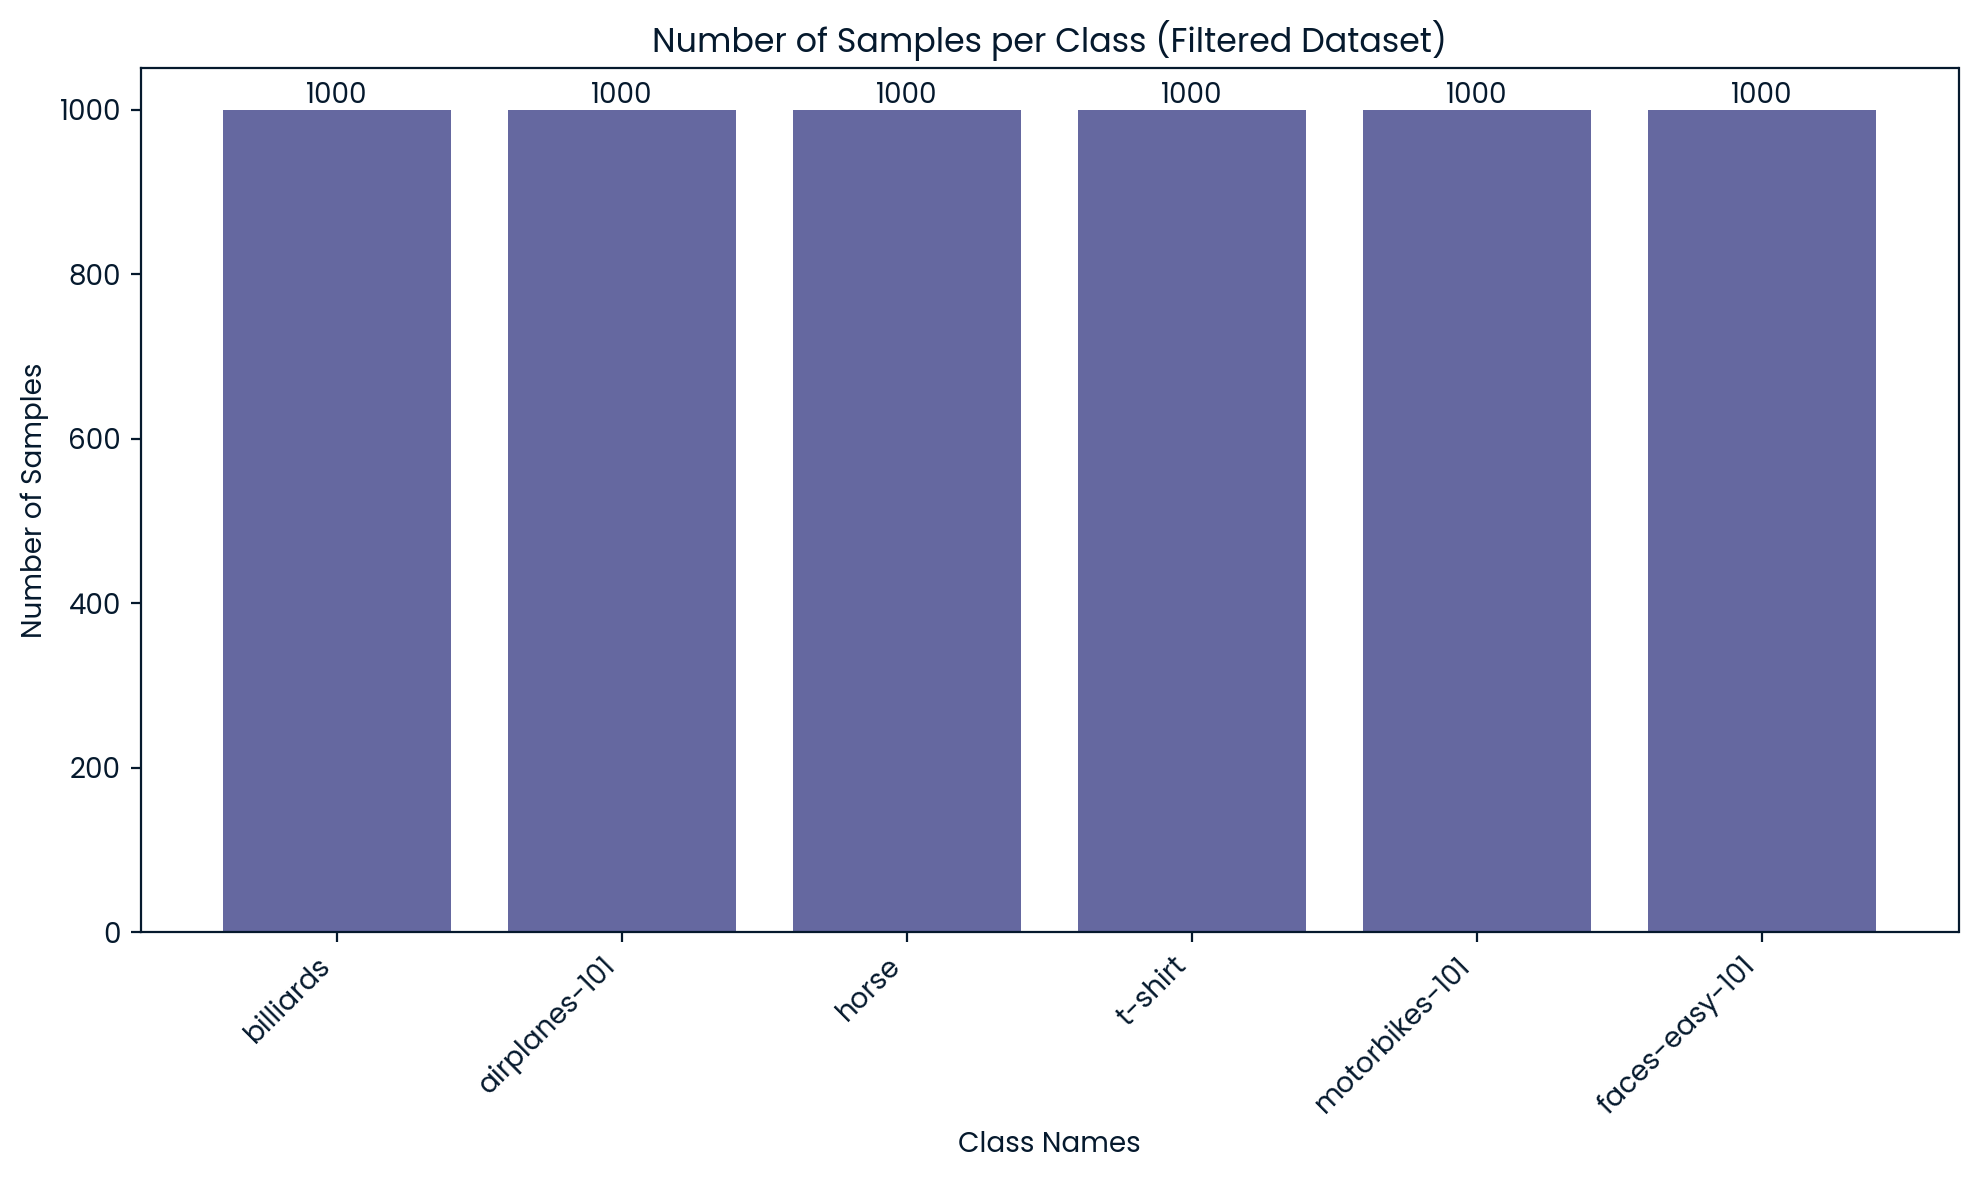

In [18]:
# Count the number of samples per class in the filtered training dataset
filtered_class_counts = Counter(example['class'] for example in augmented_filtered_dataset)

# Sort the filtered class counts by values in descending order
sorted_class_counts = dict(sorted(filtered_class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the bar chart with sorted labels
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class (Filtered Dataset)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Grayscale Image Conversion
The following code converts all images in the `augmented_filtered_dataset` to grayscale.
It uses the `.map()` function to apply the `.convert("L")` method
(from the PIL library) to each image entry in the dataset.

1220


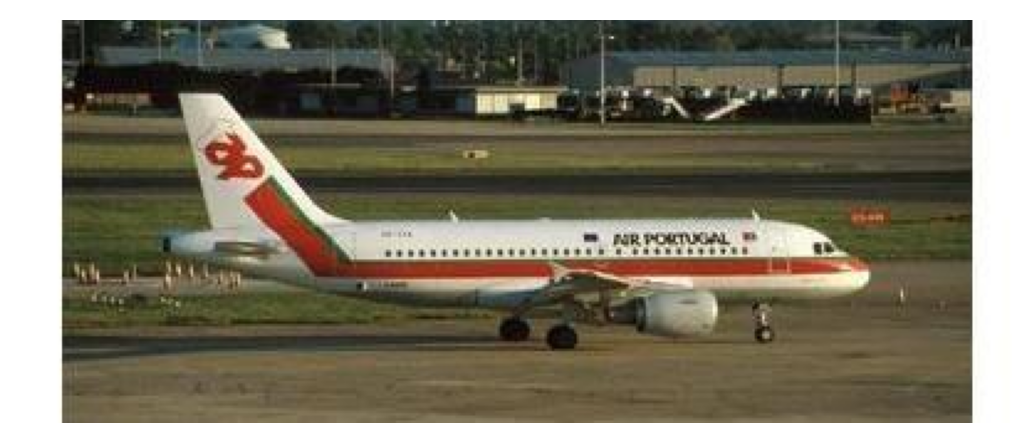

In [19]:
random_index = random.randint(0, len(augmented_filtered_dataset) - 1)
print(random_index)
random_image = augmented_filtered_dataset[random_index]['image']
plt.imshow(random_image) 
plt.axis('off')
plt.show()

In [20]:
# Transform images in the training dataset to grayscale
augmented_filtered_dataset = augmented_filtered_dataset.map(lambda example: {"image": example["image"].convert("L")})

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

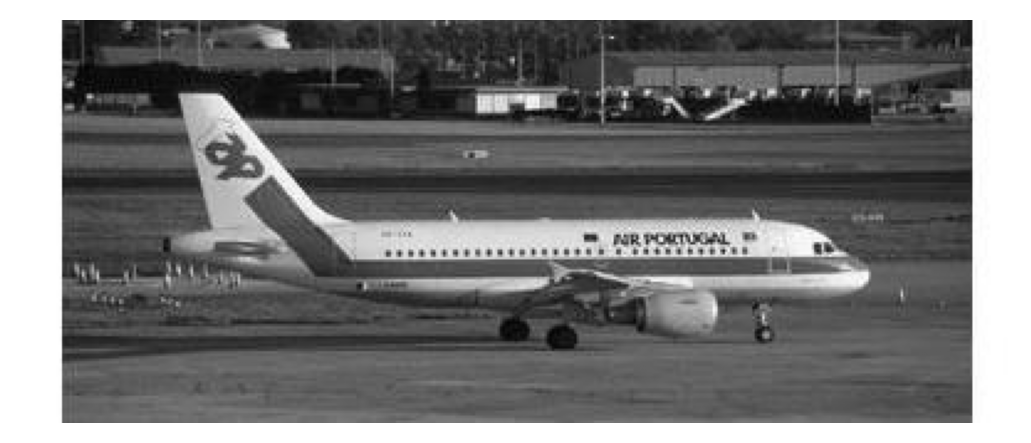

In [21]:
# Convert the PIL image to a NumPy array
random_image = augmented_filtered_dataset[random_index]['image']
image_array = np.array(random_image)

# Display the grayscale image
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.show()


### Stratified Train/Test Split (80/20)
Extracts class labels and performs a stratified train-test split on the dataset.
Uses an 80% train / 20% test ratio, ensuring proportional class representation.
Creates `train_dataset` and `test_dataset` subsets and prints their sizes.

In [22]:
# Extract class labels for stratified splitting
labels = [example['class'] for example in augmented_filtered_dataset]

# Split the dataset into train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(
    range(len(augmented_filtered_dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create train and test datasets
train_dataset = augmented_filtered_dataset.select(train_indices)
test_dataset = augmented_filtered_dataset.select(test_indices)# Extract class labels for stratified splitting

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 4800
Test dataset size: 1200


In [23]:
# TEMP FOR DEV: Select 100 random samples from the training dataset

#random_indices = random.sample(range(len(train_dataset)), 100)
#train_dataset = train_dataset.select(random_indices)

#print(f"Number of random samples selected: {len(train_dataset)}")

In [24]:
from skimage.transform import resize
EXPECTED_IMG_SIZE = 128

# --- Data Preparation ---
def resize_image(image, size):
    return resize(image, (size, size), anti_aliasing=True)

train_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in train_dataset
], dtype=np.float32)

test_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in test_dataset
], dtype=np.float32)

train_images /= 255.0
test_images /= 255.0

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

train_labels = np.array([selected_classes.index(example['class']) for example in train_dataset], dtype=np.int64)
test_labels = np.array([selected_classes.index(example['class']) for example in test_dataset], dtype=np.int64)

## 5. CNN

### CNN Training and Evaluation Pipeline
This section implements a PyTorch Convolutional Neural Network (CNN) for image classification.
It covers additional data preprocessing, model definition, training with validation,
saving the model, evaluating its final accuracy, and plotting learning curves.

In [26]:
# --- Configuration ---
EXPECTED_IMG_SIZE = 128
INPUT_CHANNELS = 1
NUM_CLASSES = 6
MODEL_SAVE_PATH = 'caltech256_model.pth'
EPOCHS = 50
BATCH_SIZE = 32

# --- Use GPU if available ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
# --- Data Preparation ---
# (Assuming train_dataset, test_dataset, and selected_classes are defined)
def resize_image(image, size):
    return resize(image, (size, size), anti_aliasing=True)

train_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in train_dataset
], dtype=np.float32)

test_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in test_dataset
], dtype=np.float32)

train_images /= 255.0
test_images /= 255.0
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

train_labels = np.array([selected_classes.index(example['class']) for example in train_dataset], dtype=np.int64)
test_labels = np.array([selected_classes.index(example['class']) for example in test_dataset], dtype=np.int64)

train_images_tensor = torch.from_numpy(train_images).permute(0, 3, 1, 2)
test_images_tensor = torch.from_numpy(test_images).permute(0, 3, 1, 2)
train_labels_tensor = torch.from_numpy(train_labels)
test_labels_tensor = torch.from_numpy(test_labels)
# ------------------------------
# --- Data Preparation ---
def resize_image(image, size):
    return resize(image, (size, size), anti_aliasing=True)

train_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in train_dataset
], dtype=np.float32)

test_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in test_dataset
], dtype=np.float32)

train_images /= 255.0
test_images /= 255.0
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

train_labels = np.array([selected_classes.index(example['class']) for example in train_dataset], dtype=np.int64)
test_labels = np.array([selected_classes.index(example['class']) for example in test_dataset], dtype=np.int64)

# Convert to PyTorch tensors
train_images_tensor = torch.from_numpy(train_images).permute(0, 3, 1, 2)
test_images_tensor = torch.from_numpy(test_images).permute(0, 3, 1, 2)
train_labels_tensor = torch.from_numpy(train_labels)
test_labels_tensor = torch.from_numpy(test_labels)

Model Definition, Training and Learning Curves Evaluation

Using device: cpu
Epoch 1/50, Loss: 1.8464, Acc: 16.83%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 2/50, Loss: 1.7917, Acc: 17.38%, Val Loss: 1.7911, Val Acc: 16.67%
Epoch 3/50, Loss: 1.7915, Acc: 16.85%, Val Loss: 1.7917, Val Acc: 16.67%
Epoch 4/50, Loss: 1.7916, Acc: 16.94%, Val Loss: 1.7895, Val Acc: 16.67%
Epoch 5/50, Loss: 1.7666, Acc: 21.98%, Val Loss: 1.6011, Val Acc: 33.17%
Epoch 6/50, Loss: 1.3414, Acc: 47.31%, Val Loss: 1.1462, Val Acc: 55.75%
Epoch 7/50, Loss: 1.0302, Acc: 60.69%, Val Loss: 0.9551, Val Acc: 63.75%
Epoch 8/50, Loss: 0.8850, Acc: 66.38%, Val Loss: 0.8234, Val Acc: 68.33%
Epoch 9/50, Loss: 0.8042, Acc: 69.67%, Val Loss: 0.7925, Val Acc: 69.08%
Epoch 10/50, Loss: 0.7353, Acc: 71.92%, Val Loss: 0.7779, Val Acc: 69.00%
Epoch 11/50, Loss: 0.6970, Acc: 73.79%, Val Loss: 0.7293, Val Acc: 70.50%
Epoch 12/50, Loss: 0.6683, Acc: 74.04%, Val Loss: 0.7120, Val Acc: 72.08%
Epoch 13/50, Loss: 0.6366, Acc: 75.65%, Val Loss: 0.6836, Val Acc: 72.25%
Epoch 14/50, Loss: 0.6162, Ac

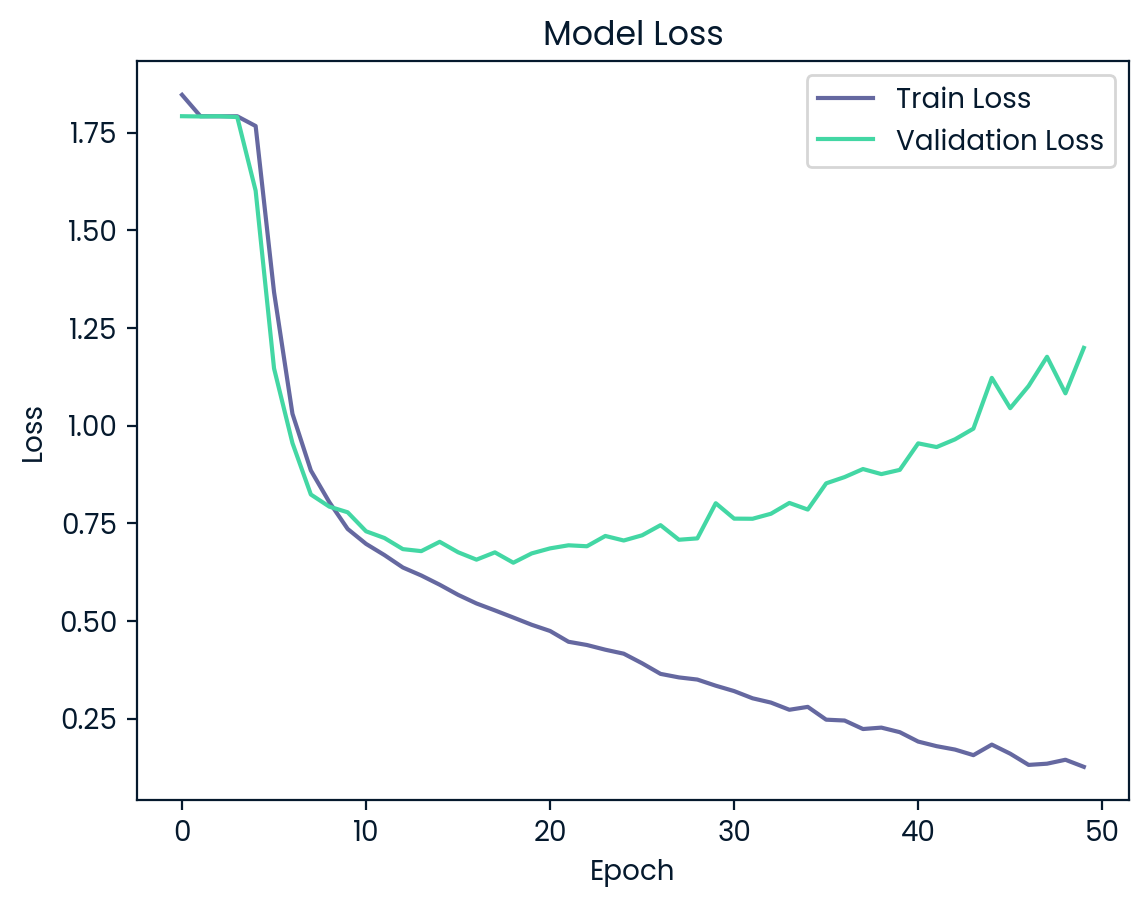

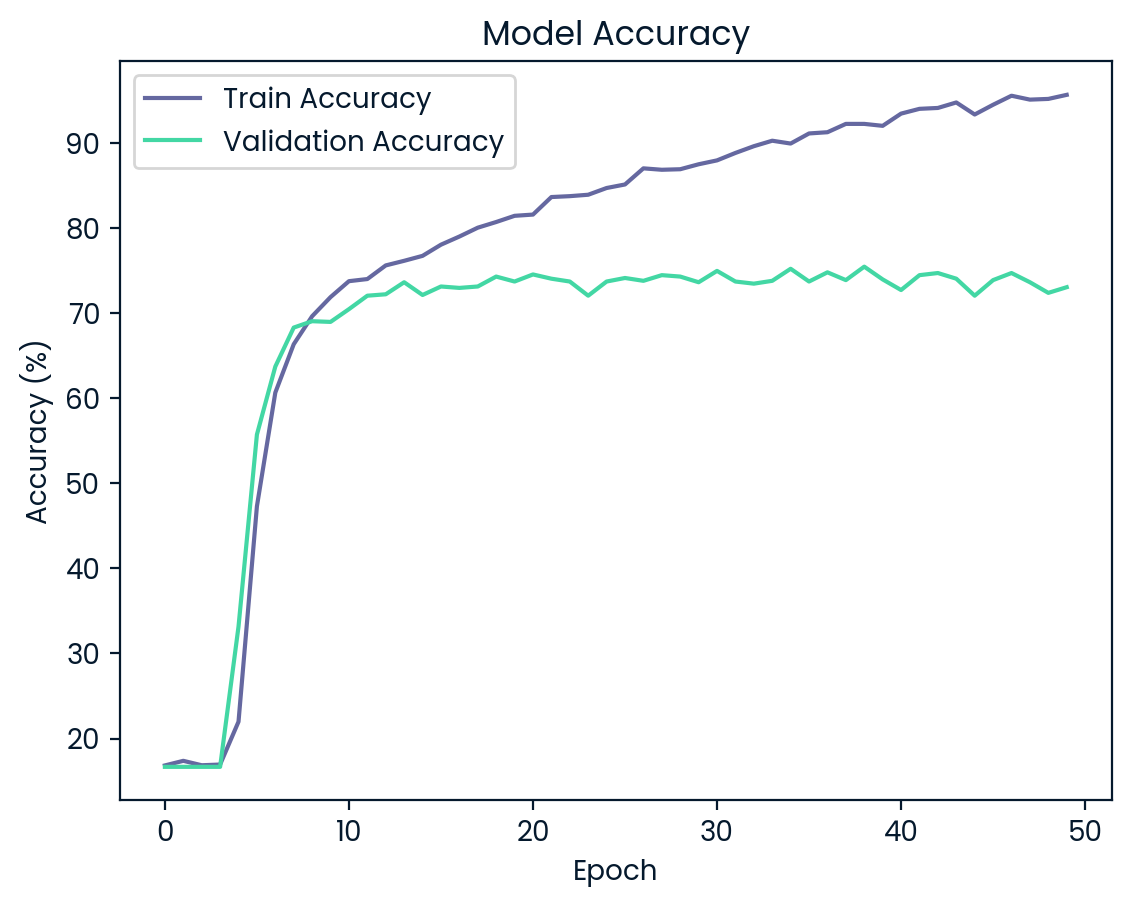

In [21]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(train_images_tensor, train_labels_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images_tensor, test_labels_tensor), batch_size=BATCH_SIZE)

# --- Model Definition ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(INPUT_CHANNELS, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        pooled_size = EXPECTED_IMG_SIZE // 2
        self.fc1 = nn.Linear(32 * pooled_size * pooled_size, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# --- Training ---
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Initialize History Dictionary ---
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

# --- Training Loop ---
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_accuracy = 100 * val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), MODEL_SAVE_PATH)

# --- Evaluation ---
eval_model = SimpleCNN().to(device)
eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
eval_model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = eval_model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")

# --- Plotting Training & Validation History ---
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


### CNN Hyperparameter Tuning with Dynamic Architecture
This extensive section sets up a pipeline for hyperparameter optimization of a CNN.
It defines a `DynamicCNN` with configurable layers, a training function with early stopping,
and a `random_search` procedure to find the best learning rate, batch size,
convolutional layers, kernel size, dropout, and optimizer.

In [25]:
# --- Dynamic CNN Model ---
class DynamicCNN(nn.Module):
    def __init__(self, num_conv_layers, filters, kernel_size, dropout_rate):
        super().__init__()
        self.conv_layers = nn.ModuleList()
        in_channels = INPUT_CHANNELS
        for i in range(num_conv_layers):
            # Use the filter value at index i, or the last value if i exceeds the length
            out_channels = filters[min(i, len(filters)-1)]
            self.conv_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
            )
            in_channels = out_channels
        
        # Calculate pooled size after conv layers (pooling after every 2 conv layers)
        pooled_size = EXPECTED_IMG_SIZE // (2 ** ((num_conv_layers + 1) // 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(filters[-1] * pooled_size * pooled_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.num_conv_layers = num_conv_layers

    def forward(self, x):
        for i, conv in enumerate(self.conv_layers):
            x = F.relu(conv(x))
            if (i + 1) % 2 == 0 or (i + 1) == self.num_conv_layers:
                x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# --- Training Function with Modified Early Stopping ---
def train_model(model, train_loader, test_loader, lr, optimizer_type, max_epochs, patience=5):
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:  # SGD with momentum
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_accuracy = 100 * val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Early stopping only after epoch 15
        if epoch >= 15:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        else:
            best_val_loss = val_loss  # Update best_val_loss even before epoch 15
            best_model_state = deepcopy(model.state_dict())
    
    # Load best model
    model.load_state_dict(best_model_state)
    return history, val_accuracy

# --- Hyperparameter Search ---
def random_search(n_trials):
    hyperparams_space = {
        'learning_rate': [0.0001, 0.001],
        'batch_size': [16, 32, 64],
        'num_conv_layers': [2, 3, 4],
        'kernel_size': [3, 5],
        'dropout_rate': [0.25, 0.5],
        'optimizer_type': ['Adam', 'SGD']
    }
    
    best_val_acc = 0
    best_params = None
    results = []
    
    for trial in range(n_trials):
        # Randomly sample hyperparameters
        params = {
            'learning_rate': random.choice(hyperparams_space['learning_rate']),
            'batch_size': random.choice(hyperparams_space['batch_size']),
            'num_conv_layers': random.choice(hyperparams_space['num_conv_layers']),
            'kernel_size': random.choice(hyperparams_space['kernel_size']),
            'dropout_rate': random.choice(hyperparams_space['dropout_rate']),
            'optimizer_type': random.choice(hyperparams_space['optimizer_type'])
        }
        
        # Dynamically generate filters based on num_conv_layers
        base_filters = [16, 32, 64]  # Base filter sizes
        params['filters'] = tuple(base_filters[:params['num_conv_layers']])
        if params['num_conv_layers'] > len(base_filters):
            params['filters'] += tuple([base_filters[-1] * 2] * (params['num_conv_layers'] - len(base_filters)))
        
        print(f"\nTrial {trial+1}/{n_trials}: {params}")
        
        # Create DataLoaders with the chosen batch size
        train_loader = DataLoader(TensorDataset(train_images_tensor, train_labels_tensor), 
                                 batch_size=params['batch_size'], shuffle=True)
        test_loader = DataLoader(TensorDataset(test_images_tensor, test_labels_tensor), 
                                batch_size=params['batch_size'])
        
        # Initialize model
        model = DynamicCNN(
            num_conv_layers=params['num_conv_layers'],
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate']
        ).to(device)
        
        # Train the model
        history, val_acc = train_model(
            model, train_loader, test_loader, 
            lr=params['learning_rate'], 
            optimizer_type=params['optimizer_type'], 
            max_epochs=EPOCHS, 
            patience=5
        )
        
        results.append((params, val_acc))
        print(f"Trial {trial+1} Validation Accuracy: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f"\nBest Hyperparameters: {best_params}")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    return results, best_params, best_val_acc

Using device: cpu


 
Now, we perform 5 trials of random hyperparameter search using the `random_search` function.
Finally, we plot the validation accuracy achieved in each trial
to visually assess the performance across different configurations.


Trial 1/5: {'learning_rate': 0.001, 'batch_size': 16, 'num_conv_layers': 2, 'kernel_size': 5, 'dropout_rate': 0.25, 'optimizer_type': 'SGD', 'filters': (16, 32)}
Epoch 1/50, Loss: 1.7934, Acc: 16.35%, Val Loss: 1.7921, Val Acc: 16.67%
Epoch 2/50, Loss: 1.7923, Acc: 16.31%, Val Loss: 1.7919, Val Acc: 16.67%
Epoch 3/50, Loss: 1.7921, Acc: 16.85%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 4/50, Loss: 1.7924, Acc: 16.25%, Val Loss: 1.7920, Val Acc: 16.67%
Epoch 5/50, Loss: 1.7922, Acc: 16.40%, Val Loss: 1.7919, Val Acc: 16.67%
Epoch 6/50, Loss: 1.7921, Acc: 16.10%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 7/50, Loss: 1.7921, Acc: 16.08%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 8/50, Loss: 1.7921, Acc: 16.19%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 9/50, Loss: 1.7921, Acc: 15.29%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 10/50, Loss: 1.7920, Acc: 15.10%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 11/50, Loss: 1.7920, Acc: 15.62%, Val Loss: 1.7918, Val Acc: 16.67%
Epoch 12/50, Loss: 1.7920, Acc: 

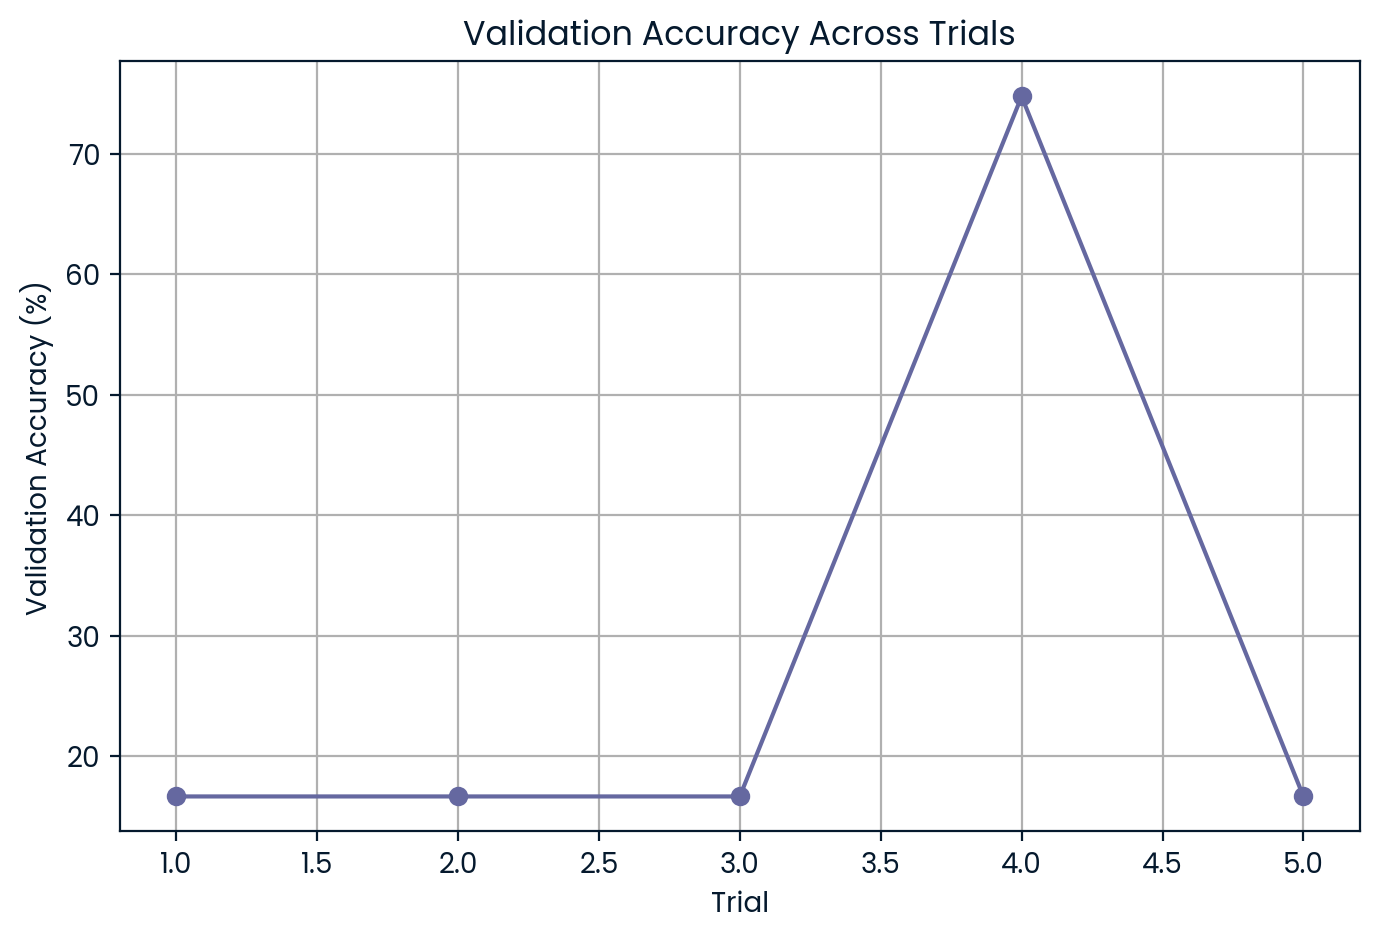

In [26]:
# --- Run Random Search ---
n_trials = 5  # Number of random trials
results, best_params, best_val_acc = random_search(n_trials)

# --- Plot Results for Analysis ---
val_accs = [result[1] for result in results]
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_trials+1), val_accs, marker='o')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Across Trials')
plt.grid(True)
plt.show()

### Final Model Training with Best Hyperparameters
Now, we train the final `DynamicCNN` using combined train/validation data.
It employs a specific hyperparameter set (derived from "Trial 4") and validates on the test set.
Metrics like error, precision, recall, and F1-score are reported, and the best model is saved.

In [25]:
params = {
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_conv_layers': 2,
    'kernel_size': 5,
    'dropout_rate': 0.25,
    'optimizer_type': 'Adam',
    'filters': (16, 32)
}

In [20]:
# --- Data Preparation ---
# (Assuming train_dataset, test_dataset, and selected_classes are defined)
def resize_image(image, size):
    return resize(image, (size, size), anti_aliasing=True)

train_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in train_dataset
], dtype=np.float32)

test_images = np.array([
    resize_image(np.array(example['image']), EXPECTED_IMG_SIZE)
    for example in test_dataset
], dtype=np.float32)

train_images /= 255.0
test_images /= 255.0
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

train_labels = np.array([selected_classes.index(example['class']) for example in train_dataset], dtype=np.int64)
test_labels = np.array([selected_classes.index(example['class']) for example in test_dataset], dtype=np.int64)

train_images_tensor = torch.from_numpy(train_images).permute(0, 3, 1, 2)
test_images_tensor = torch.from_numpy(test_images).permute(0, 3, 1, 2)
train_labels_tensor = torch.from_numpy(train_labels)
test_labels_tensor = torch.from_numpy(test_labels)

# Combine train and validation datasets for final training
combined_images_tensor = torch.cat((train_images_tensor, test_images_tensor), dim=0)
combined_labels_tensor = torch.cat((train_labels_tensor, test_labels_tensor), dim=0)

# --- Dynamic CNN Model ---
class DynamicCNN(nn.Module):
    def __init__(self, num_conv_layers, filters, kernel_size, dropout_rate):
        super().__init__()
        self.conv_layers = nn.ModuleList()
        in_channels = INPUT_CHANNELS
        for i in range(num_conv_layers):
            out_channels = filters[min(i, len(filters)-1)]
            self.conv_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
            )
            in_channels = out_channels
        
        pooled_size = EXPECTED_IMG_SIZE // (2 ** ((num_conv_layers + 1) // 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(filters[-1] * pooled_size * pooled_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.num_conv_layers = num_conv_layers

    def forward(self, x):
        for i, conv in enumerate(self.conv_layers):
            x = F.relu(conv(x))
            if (i + 1) % 2 == 0 or (i + 1) == self.num_conv_layers:
                x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# --- Training Function with Metrics ---
def train_final_model(model, train_loader, test_loader, lr, optimizer_type, max_epochs, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_type == 'Adam' else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        # Validation (using test_loader as validation set)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= val_total
        val_accuracy = 100 * val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # Calculate metrics
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        error = 100 - val_accuracy  # Error = 100 - accuracy
        
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, "
              f"Error: {error:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        # Early stopping only after epoch 15
        if epoch >= 15:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        else:
            best_val_loss = val_loss
            best_model_state = deepcopy(model.state_dict())
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation on test set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    final_accuracy = accuracy_score(all_labels, all_preds) * 100
    final_error = 100 - final_accuracy
    final_precision = precision_score(all_labels, all_preds, average='weighted')
    final_recall = recall_score(all_labels, all_preds, average='weighted')
    final_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"\nFinal Metrics on Test Set - Error: {final_error:.2f}%, Accuracy: {final_accuracy:.2f}%, "
          f"Precision: {final_precision:.4f}, Recall: {final_recall:.4f}, F1: {final_f1:.4f}")
    
    return model, history

# Create DataLoaders
train_loader = DataLoader(TensorDataset(combined_images_tensor, combined_labels_tensor), 
                          batch_size=params['batch_size'], shuffle=True)
test_loader = DataLoader(TensorDataset(test_images_tensor, test_labels_tensor), 
                         batch_size=params['batch_size'])

# Initialize model
model = DynamicCNN(
    num_conv_layers=params['num_conv_layers'],
    filters=params['filters'],
    kernel_size=params['kernel_size'],
    dropout_rate=params['dropout_rate']
).to(device)

# Train the model
model, history = train_final_model(
    model, train_loader, test_loader, 
    lr=params['learning_rate'], 
    optimizer_type=params['optimizer_type'], 
    max_epochs=EPOCHS, 
    patience=5
)

# Save the final model
torch.save(model.state_dict(), MODEL_SAVE_PATH)

Using device: cpu
Epoch 1/50, Loss: 1.8097, Acc: 16.63%, Val Loss: 1.7924, Val Acc: 16.67%, Error: 83.33%, Precision: 0.0278, Recall: 0.1667, F1: 0.0476
Epoch 2/50, Loss: 1.7924, Acc: 16.67%, Val Loss: 1.7921, Val Acc: 16.67%, Error: 83.33%, Precision: 0.0278, Recall: 0.1667, F1: 0.0476
Epoch 3/50, Loss: 1.7921, Acc: 16.67%, Val Loss: 1.7919, Val Acc: 16.67%, Error: 83.33%, Precision: 0.0278, Recall: 0.1667, F1: 0.0476
Epoch 4/50, Loss: 1.7921, Acc: 16.37%, Val Loss: 1.7918, Val Acc: 16.67%, Error: 83.33%, Precision: 0.0278, Recall: 0.1667, F1: 0.0476
Epoch 5/50, Loss: 1.7920, Acc: 16.65%, Val Loss: 1.7917, Val Acc: 16.67%, Error: 83.33%, Precision: 0.0278, Recall: 0.1667, F1: 0.0476
Epoch 6/50, Loss: 1.7918, Acc: 16.23%, Val Loss: 1.7914, Val Acc: 16.67%, Error: 83.33%, Precision: 0.0278, Recall: 0.1667, F1: 0.0476
Epoch 7/50, Loss: 1.7900, Acc: 16.90%, Val Loss: 1.7813, Val Acc: 14.75%, Error: 85.25%, Precision: 0.0709, Recall: 0.1475, F1: 0.0943
Epoch 8/50, Loss: 1.4714, Acc: 38.60%